In [1]:
import graph_tool.all as gt
import sys, os
sys.path.insert(0, '..')
import graph_embeddings
from utils.score import statistical_parity
import faiss
import residual2vec as rv
import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import kneighbors_graph
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder



Bad key "text.kerning_factor" on line 4 in
/home/ashutosh/miniconda3/envs/study/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
2022-08-04 12:59:53.186104: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-08-04 12:59:53.206366: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2304000000 Hz
2022-08-04 12:59:53.206917: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556521f8bc50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-04 12:59:53.206946: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-04 12:59:53

In [2]:

DATA_FILE = '../data/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')

nodes = G.nodes(data=True)
labels, group_ids = np.unique([n[1]['value'] for n in nodes], return_inverse=True)

A = nx.adjacency_matrix(G).asfptype()
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)

models = {}
window_length = 5
num_walks = 10
dim = 128

models["unbiased"] = graph_embeddings.DeepWalk(window_length=window_length, num_walks=num_walks, restart_prob=0)

models["degree-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80
)

models["group-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length,
    ),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)

models["fairwalk"] = graph_embeddings.Fairwalk(window_length=window_length, num_walks=num_walks)
models["fairwalk-group-unbiased"] = graph_embeddings.Fairwalk(
    window_length=window_length, num_walks=num_walks, group_membership=group_ids
)
models['GCN'] = graph_embeddings.GCN()
models["gcn-doubleK"] = graph_embeddings.GCN(num_default_features=dim * 2)
models["graphsage"] = graph_embeddings.GraphSage()
models["graphsage-doubleK"] = graph_embeddings.GraphSage(num_default_features=dim * 2)
models["gat"] = graph_embeddings.GAT(layer_sizes=[64, 256])
models["gat-doubleK"] = graph_embeddings.GAT(num_default_features=dim * 2)

In [3]:
A[0:].todense(), A.shape

(matrix([[0., 1., 1., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 1., 0.]]),
 (105, 105))

In [4]:
embs = {}

for k, model in tqdm(models.items()):
    print(model.__class__.__name__)
    sys.stdout = open(os.devnull, 'w')
    emb = model.fit(A).transform(dim=dim)
    sys.stdout = sys.__stdout__
    embs[k] = emb

  9%|████                                        | 1/11 [00:00<00:01,  7.64it/s]

DeepWalk
residual2vec_sgd



  0%|                                        | 0/329 [00:00<?, ?it/s, loss=1.17]


 30%|████████▊                    | 100/329 [00:00<00:00, 324.03it/s, loss=1.13]


 61%|███████████████████▍            | 200/329 [00:00<00:00, 359.11it/s, loss=1]


  0%|                                        | 0/329 [00:00<?, ?it/s, loss=1.34]

residual2vec_sgd



 30%|████████▊                    | 100/329 [00:00<00:00, 342.89it/s, loss=1.25]


 61%|█████████████████▋           | 200/329 [00:00<00:00, 363.53it/s, loss=1.26]


 27%|████████████                                | 3/11 [00:06<00:18,  2.29s/it]

Fairwalk


 36%|████████████████                            | 4/11 [00:06<00:10,  1.46s/it]

Fairwalk


 45%|████████████████████                        | 5/11 [00:07<00:06,  1.01s/it]

GCN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 55%|████████████████████████                    | 6/11 [00:14<00:15,  3.05s/it]

GCN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 64%|████████████████████████████                | 7/11 [00:23<00:20,  5.11s/it]

GraphSage
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

2022-08-04 13:00:19.257814: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-04 13:00:19.900886: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-04 13:00:20.543167: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-04 13:00:21.202484: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-04 13:00:21.859144: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-04 13:00:22.429929: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error o

GraphSage
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

2022-08-04 13:00:24.299035: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-04 13:00:24.965717: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-04 13:00:25.622413: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-04 13:00:26.260980: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-04 13:00:26.924928: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-04 13:00:27.484503: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error o

GAT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 91%|███████████████████████████████████████    | 10/11 [00:47<00:07,  7.73s/it]

GAT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
  ...
    to  
  ['...']
  ...
    to  
  ['...']


100%|███████████████████████████████████████████| 11/11 [01:01<00:00,  5.64s/it]


class score:  unbiased 0.1431965836314554
class score:  degree-unbiased 0.15172799379157492
class score:  group-unbiased 0.11992881821479172
class score:  fairwalk 0.14409441418771243
class score:  fairwalk-group-unbiased 0.16354448391327095
class score:  GCN 0.17724950765684946
class score:  gcn-doubleK 0.1721389102852752
class score:  graphsage 0.08268683737433588
class score:  graphsage-doubleK 0.08181033657709182
class score:  gat 0.17274178600403958
class score:  gat-doubleK 0.08722859813762736


In [5]:

def reconstruct_graph(emb, n, m):
    # choose top m edges to reconstruct the graph
    S = emb @ emb.T
    S = np.triu(S, k=1)
    r, c, v = sparse.find(S)
    idx = np.argsort(-v)[:m]
    r, c, v = r[idx], c[idx], v[idx]
    B = sparse.csr_matrix((v, (r, c)), shape=(n, n))
    B = B + B.T
    B.data = B.data * 0 + 1
    return nx.from_scipy_sparse_matrix(B + B.T)



In [6]:
n_edges = int(A.sum() / 2)
n_nodes = A.shape[0]
rgraphs = {}
for k, emb in embs.items():
    rgraphs[k] = reconstruct_graph(emb, n_nodes, n_edges)

In [7]:
scores = {}
for k, graph in rgraphs.items():
    scores[k] = statistical_parity(graph, group_ids)
    print("class score: ", k, scores[k])

100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3924.80it/s]


[Text(0,0,'unbiased'),
 Text(0,0,'degree-unbiased'),
 Text(0,0,'group-unbiased'),
 Text(0,0,'fairwalk'),
 Text(0,0,'fairwalk-group-unbiased'),
 Text(0,0,'GCN'),
 Text(0,0,'gcn-doubleK'),
 Text(0,0,'graphsage'),
 Text(0,0,'graphsage-doubleK'),
 Text(0,0,'gat'),
 Text(0,0,'gat-doubleK')]

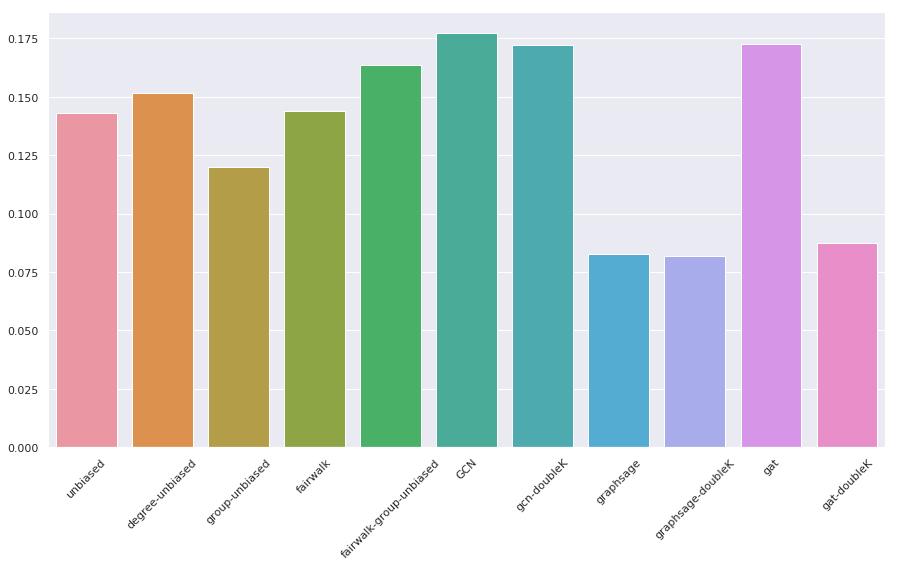

In [8]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [9]:
import pickle as pkl
pkl.dump(rgraphs, open('/tmp/rgraphs.pkl', 'wb'))
pkl.dump(group_ids, open('/tmp/group_ids.pkl', 'wb'))
pkl.dump(embs, open('/tmp/embs.pkl', 'wb'))
